In [1]:
import random
from functools import partial
from pathlib import Path

from matplotlib.pyplot import figure, plot
from torch import Generator, Tensor, histogram, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.models.components.component import ComponentRecorder
from karpathy_series.makemore.models.components.functional import Functional
from karpathy_series.makemore.models.generation import NGramNetGenerator
from karpathy_series.makemore.models.mlp import MPLNet
from karpathy_series.makemore.training.data import DataSplit, TrainingSequencer
from karpathy_series.makemore.training.learning import Learner

random.seed(42)

%matplotlib inline
use_deterministic_algorithms(True)
rand_generator = Generator()
seed = 2147483647


def create_generator():
    return rand_generator.manual_seed(seed)

In [2]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 4
embedding_dims = 10
hidden_dims = 200

n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)
data_split = DataSplit.split(words, 80, 10, 10)
learning_sequence = ts.training_sequence(data_split.training, 32, True)
validation_set = ts.training_set(data_split.validation)

In [8]:
g = rand_generator.manual_seed(seed)
mpl_net = MPLNet.init(4, char_encoder.size, embedding_dims, context_size, hidden_dims, g)
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net)
losses = []
print(f"{mpl_net.layers.size()} parameters")
print(f"{mpl_net.layers.describe()} parameters")

136151 parameters
Sequence [Embedding [27, 10], Flatten last 2 dims, Linear [40, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f6dc4e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f6dc4e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f6dc4e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f6dc4e149e0>, Linear [200, 27] with bias, BatchNorm1d [27]] parameters


In [4]:
learner = Learner(mpl_net, 0.1)
losses += learner(learning_sequence, epochs=10, report_epochs=1)

Epoch 1 is finished with loss = 2.314196825027466
Epoch 2 is finished with loss = 2.0349819660186768
Epoch 3 is finished with loss = 2.0963284969329834
Epoch 4 is finished with loss = 2.1047370433807373
Epoch 5 is finished with loss = 2.283479928970337
Epoch 6 is finished with loss = 1.9393707513809204
Epoch 7 is finished with loss = 2.083784818649292
Epoch 8 is finished with loss = 2.188730478286743
Epoch 9 is finished with loss = 2.0873656272888184
Epoch 10 is finished with loss = 2.0275626182556152


In [5]:
print(mpl_net.run(*validation_set))

tensor(2.0697, grad_fn=<NllLossBackward0>)


In [6]:
for k in range(20):
    print(generator())

sharlen
jessala
konte
elyn
asalyn
jhoda
mahemad
maedyn
orynnlisa
josamana
livin
anah
mail
braeden
japensley
marki
emellaiah
coviairah
itaf
ryoni


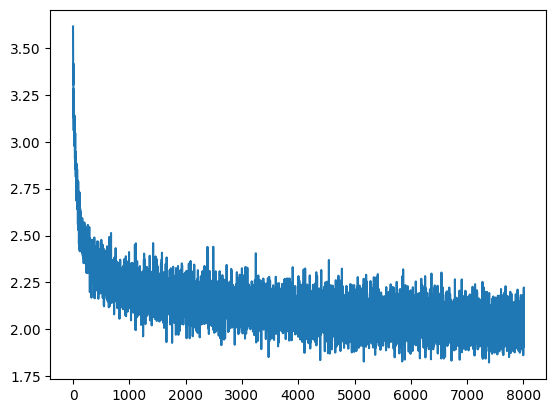

In [7]:
plot(tensor(losses))

In [9]:
record = ComponentRecorder()
loss = mpl_net.step(*next(learning_sequence()), record=record)
print(f"Step loss = {loss: .4f}")

Step loss =  3.6885


layer   4 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean  0.0013, std  0.6273, saturation  3.62%
layer   7 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean -0.0005, std  0.6336, saturation  3.33%
layer  10 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean  0.0011, std  0.6367, saturation  3.22%
layer  13 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean -0.0009, std  0.6355, saturation  3.15%


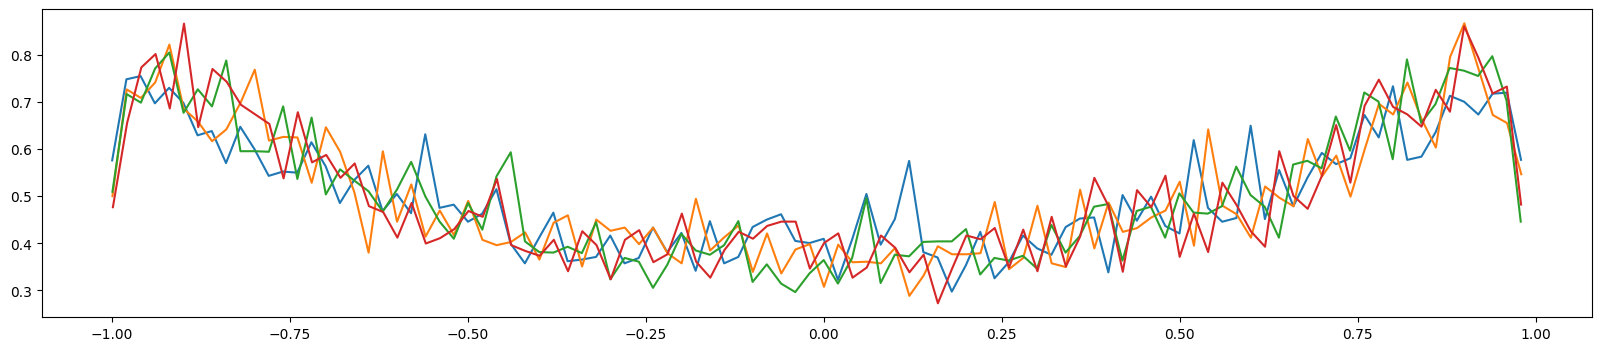

In [10]:
def saturation(out: Tensor) -> float:
    return (out.abs() > 0.97).float().mean()


figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.mean(): .4f}, std {out.std(): .4f}, saturation {saturation(out): .2%}")
        hy, hx = histogram(out, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

layer   4 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean  0.0000, std  0.0007
layer   7 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean -0.0000, std  0.0006
layer  10 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean  0.0000, std  0.0005
layer  13 Functional <built-in method tanh of type object at 0x7f6dc4e149e0>: mean  0.0000, std  0.0005


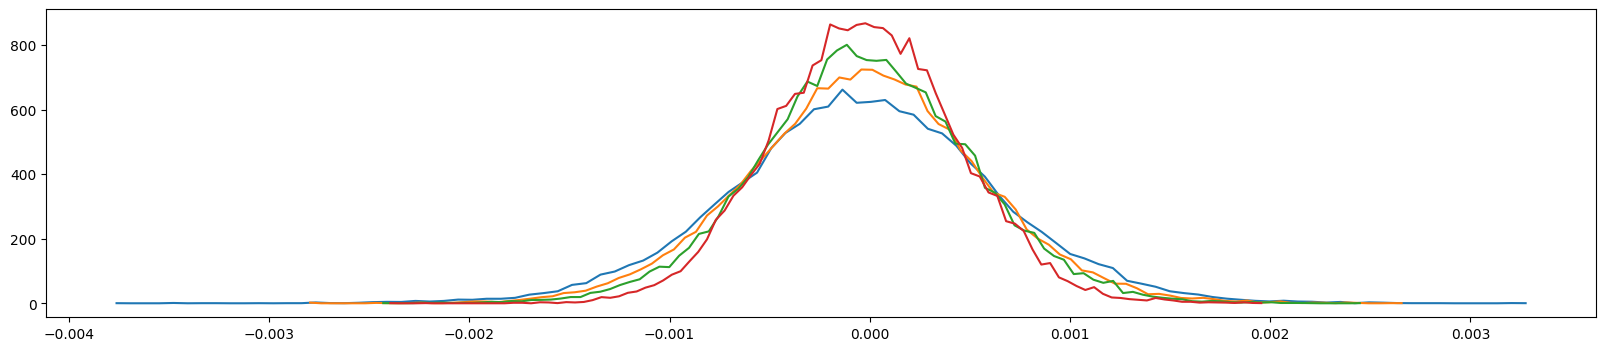

In [11]:
figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.grad.mean(): .4f}, std {out.grad.std(): .4f}")
        hy, hx = histogram(out.grad, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")